# Data understanding
In diesem Notebook werden die für diese Arbeit potentiel wichtigen Informationen in Wikidata explorativ begutachtet.  
Der Code ruf die Daten mittels [Wikidata Query Service](https://query.wikidata.org/) ab.

In diesem Notebooks soll herausgefunden werden, welche Strassen in Basel in Wikidata erfasst sind. Dies hat zwei Ziele:
1. Wie kann der Wikidata Query Service mittels Python angesprochen werden. Dies ist wichtig da später die Strassennamen mit den Einträgen in Wikidata abgeglichen weden sollen.
2. Sind bereits Strassen in Basel in Wikidata erfasst und besitzen die gegebenfalls bereits eine verlinkung zu dem namensgebenden Objekt. Dies könnte interessant sein, da die Informationen für eine Qualitätskontrolle des Abgleichprozesses genutzt werden könnten.

## Strassen mit Wikidata in Basel in OSM
In Wikidata ist es nicht so einfach alle Strassen oder alle Objekte in Basel zu finden, da es keine direkte geografische Abfrage gibt (oder sie ist den Autoren zumindest nicht bekannt). Es kann nur abgefragt werden, welche Strassen ein Statement "liegt in Basel" vergeben wurde, wobei für Basel theoretisch sowohl die Stadt als auch der Kanton verwendet werden kann.  
Deshal wird zuerst überprüft, ob allenfalls in OpenStreetMap bereits Strassen im Kanton Basel mit einem [Wikidata Key](https://wiki.openstreetmap.org/wiki/Key:wikidata) versehen sind.


In [1]:
import requests

#overpass_url = "http://overpass-api.de/api/interpreter"
overpass_url = "https://lz4.overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-2"="CH-BS"];
(
nwr["wikidata"]["highway"](area);
);
(._;>;);
out body;
"""

response = requests.get(overpass_url, data = overpass_query)
print(response)

<Response [200]>


In [2]:
data = response.json()

In [3]:
#print(data["elements"])

In [4]:
import pandas as pd
dfp = pd.DataFrame(data["elements"])

In [5]:
!pip install osm2geojson
import osm2geojson

geojson = osm2geojson.json2geojson(data)

In [6]:
import geopandas as gpd
points = gpd.GeoDataFrame.from_features(geojson, crs="EPSG:4326")

TODO: Das Attribut name aus der Spalte tags extrahieren

In [7]:
points.head(2)

,geometry,type,id,tags,nodes
0,"LINESTRING (7.58169 47.56651, 7.58164 47.56659...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475..."
1,"LINESTRING (7.59802 47.53632, 7.59818 47.53632...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827..."


In [8]:
#from pandas.io.json import json_normalize
points2 = pd.json_normalize(points.to_dict('list'), ['tags'])
points2.head(2)

,highway,lanes,lit,maxspeed,name,oneway,sidewalk,surface,wikidata,name:etymology:wikidata,...,lanes:backward,lanes:forward,turn:lanes:backward,turn:lanes:forward,tunnel,cycleway:left:lane,access,foot,covered,cycleway:both:lane
0,tertiary,2,yes,50,Elsässerstrasse,no,both,asphalt,Q111632663,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,residential,NaN,NaN,NaN,Albert Schweitzer-Strasse,NaN,NaN,asphalt,Q27067517,Q49325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dfGeo = pd.concat([points, points2[["name", "wikidata"]]], axis = 1)
dfGeo.head(2)

,geometry,type,id,tags,nodes,name,wikidata
0,"LINESTRING (7.58169 47.56651, 7.58164 47.56659...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475...",Elsässerstrasse,Q111632663
1,"LINESTRING (7.59802 47.53632, 7.59818 47.53632...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827...",Albert Schweitzer-Strasse,Q27067517


In [10]:
dfGeo = dfGeo.to_crs(epsg=3857)

In [11]:
dfGeo.head(2)

,geometry,type,id,tags,nodes,name,wikidata
0,"LINESTRING (843990.282 6035037.672, 843984.249...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475...",Elsässerstrasse,Q111632663
1,"LINESTRING (845807.862 6030058.573, 845825.618...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827...",Albert Schweitzer-Strasse,Q27067517


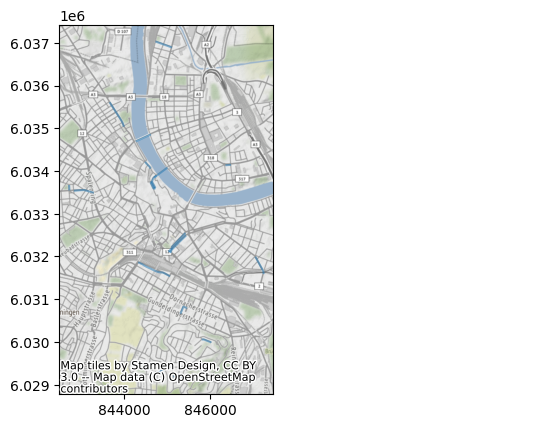

In [12]:
import contextily as cx
ax = dfGeo.plot(alpha=0.5)
cx.add_basemap(ax)


In [13]:
# Wird nur gebraucht sollte eine interaktive Karte angezeigt werden 
# !pip install folium matplotlib mapclassify

In [14]:
# Zeigt die interaktive Karte an
# dfGeo.explore(tooltip=["name", "wikidata"], width="70%", height="70%")

### Wikidata Informationen abfragen
Herausfinden, welchen "Typ" (Wikidata-Property [instance of](https://www.wikidata.org/wiki/Property:P31)) die Elemente aufweisen.  
Informationen von: https://people.wikimedia.org/~bearloga/notes/wdqs-python.html

In [15]:
!pip install SPARQLWrapper

In [16]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

In [17]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

In [18]:
dfGeo['wdInstance'] = ""

dfGeo.head()

,geometry,type,id,tags,nodes,name,wikidata,wdInstance
0,"LINESTRING (843990.282 6035037.672, 843984.249...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475...",Elsässerstrasse,Q111632663,
1,"LINESTRING (845807.862 6030058.573, 845825.618...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827...",Albert Schweitzer-Strasse,Q27067517,
2,"LINESTRING (846361.654 6034133.663, 846469.311...",way,4856065,"{'cycleway:right': 'lane', 'cycleway:right:lan...","[3319171, 31317890, 3319853]",Wettsteinallee,Q111632702,
3,"LINESTRING (844263.215 6034692.057, 844281.427...",way,13251973,"{'bridge': 'yes', 'cycleway:left': 'share_busw...","[122336617, 1175169798, 1534406794]",Johanniterbrücke,Q1547778,
4,"LINESTRING (845111.726 6036888.945, 844919.466...",way,23348438,"{'highway': 'residential', 'lit': 'yes', 'maxs...","[252822626, 252822619, 6766893398, 6814713514,...",Ackerstrasse,Q27062475,


In [19]:
def queryWd(sparql, wdKey):
    sparql.setQuery("""
    SELECT ?instance ?instanceLabel 
    WHERE 
    {
    wd:Q111632663 wdt:P31 ?instance.
    SERVICE wikibase:label { bd:serviceParam wikibase:language "de" . }
    }
    """)
    sparql.setReturnFormat(JSON)
    return sparql
    

In [20]:
for x in dfGeo.index:
    #print(dfGeo['wikidata'][x])
    sparql = queryWd(sparql, "")
    results = sparql.query().convert()
    results_df = pd.json_normalize(results['results']['bindings'])
    #print(results_df[['instanceLabel.value']])
    dfGeo.at[x, "wdInstance"] = results_df['instanceLabel.value'][0]

In [21]:
dfGeo.head()

,geometry,type,id,tags,nodes,name,wikidata,wdInstance
0,"LINESTRING (843990.282 6035037.672, 843984.249...",way,4303427,"{'highway': 'tertiary', 'lanes': '2', 'lit': '...","[107573910, 1435404974, 6802037975, 5827696475...",Elsässerstrasse,Q111632663,Innerortsstraße
1,"LINESTRING (845807.862 6030058.573, 845825.618...",way,4803840,"{'highway': 'residential', 'name': 'Albert Sch...","[30827754, 30827755, 30827756, 30827757, 30827...",Albert Schweitzer-Strasse,Q27067517,Innerortsstraße
2,"LINESTRING (846361.654 6034133.663, 846469.311...",way,4856065,"{'cycleway:right': 'lane', 'cycleway:right:lan...","[3319171, 31317890, 3319853]",Wettsteinallee,Q111632702,Innerortsstraße
3,"LINESTRING (844263.215 6034692.057, 844281.427...",way,13251973,"{'bridge': 'yes', 'cycleway:left': 'share_busw...","[122336617, 1175169798, 1534406794]",Johanniterbrücke,Q1547778,Innerortsstraße
4,"LINESTRING (845111.726 6036888.945, 844919.466...",way,23348438,"{'highway': 'residential', 'lit': 'yes', 'maxs...","[252822626, 252822619, 6766893398, 6814713514,...",Ackerstrasse,Q27062475,Innerortsstraße


In [22]:
#ToDo
#1 Sind alle Strassen von der Instance=Innerortsstraße?
#2 Gibt es in Wikidata noch andere Strassen der Instance=Innerortsstraße?

query = """SELECT ?nativename ?streetkey WHERE {
				?streetname wdt:P1945 ?streetkey;
				wdt:P131 wd:Q72;
				wdt:P1705 ?nativename.
				SERVICE wikibase:label { bd:serviceParam wikibase:language "de" . } 
				}"""


